<a href="https://colab.research.google.com/github/Yun5141/comp0036/blob/master/FootballResultPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction [*Terry*]

# 2. Data Import  [*Yun*]

We first import all the packages that will be used in the code:

In [104]:
import pandas as pd 

import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

#!pip3 install geopy
from geopy.distance import geodesic 
from geopy.distance import great_circle 

#!pip3 install sklearn
import sklearn
from sklearn.preprocessing import scale

And then the data sets from our github repository (https://github.com/Yun5141/comp0036):

In [70]:
# training data set
url="https://raw.githubusercontent.com/Yun5141/comp0036/master/data/epl-training.csv"
raw_training_data=pd.read_csv(url)

# test set
url = 'https://raw.githubusercontent.com/Yun5141/comp0036/master/data/epl-test.csv'
rawData_toPred = pd.read_csv(url)

# 2019 up-to-date data (from http://www.football-data.co.uk)
url = 'https://raw.githubusercontent.com/Yun5141/comp0036/master/data/epl2019.csv'
rawData_2019_uptodate = pd.read_csv(url)

# geometric information of teams
# to calculate the distance needed to travel for the away team
url = "https://raw.githubusercontent.com/Yun5141/comp0036/master/data/stadiums-with-GPS-coordinates.csv"
geometricData = pd.read_csv(url)

# 3. Data Transformation & Exploration [*Yun*]

### 3.1 Initial Data Exploration

We first visualize the raw training data and find that:
- The shape of the dataframe is 4180 rows x 73 columns, but some columns are empty and unamed.
- There are two different date formats, "%d/%m/%y" and "%d/%m/%Y".
- The involved data is from 2008-08-16 to 2019-05-12 (i.e. there are totally 11 seasons).

In [71]:
raw_training_data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72
0,16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,12/05/2019,Liverpool,Wolves,2,0,H,1,0,H,M Atkinson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4176,12/05/2019,Man United,Cardiff,0,2,A,0,1,A,J Moss,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4177,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,L Probert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4178,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,A Marriner,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We drop the unamed columns and find now the shape of the dataframe is 4180 rows x 22 columns.

In [72]:
raw_training_data = raw_training_data[raw_training_data.columns[~raw_training_data.columns.str.contains('Unnamed:')]]
raw_training_data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,...,14,4,11,8,7,5,0,0,0,0
1,16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,...,8,2,13,12,4,3,1,2,0,0
2,16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,...,5,11,11,9,3,5,2,2,0,0
3,16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,...,6,6,10,9,5,6,3,0,0,0
4,16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,...,10,5,11,12,7,9,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,12/05/2019,Liverpool,Wolves,2,0,H,1,0,H,M Atkinson,...,5,2,3,11,4,1,0,2,0,0
4176,12/05/2019,Man United,Cardiff,0,2,A,0,1,A,J Moss,...,10,4,9,6,11,2,3,3,0,0
4177,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,L Probert,...,3,3,8,6,4,3,0,1,0,0
4178,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,A Marriner,...,3,9,10,13,7,4,0,2,0,0


##### 3.1.1 Invalid data

We then check if there are rows containing None, NaN, infinite or overflowed values:

In [73]:
def removeInvalidData(data):

    # remove data which contains None
    data.dropna(axis=0, how='any',inplace=True)

    # remove data which contains NaN, infinite or overflowed number 
    indices_to_keep = ~data.isin([np.nan, np.inf, -np.inf]).any(1)
    data = data[indices_to_keep]

    return data

assert raw_training_data.shape[0] == removeInvalidData(raw_training_data).shape[0]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


The result indicates that there is no rows containing such values.

##### 3.1.2 Number of matches per season

The training set is of huge amount. To help learning the data, we separate the data set by seasons (from August to May) to see how many matches there are in each year.

Before splitting the data set, we need to unify the date format first.

In [74]:
# unify the different date formats and convert the type from str to timestamp  
def unifyDate(data):

    if not isinstance(data.Date[0],str):
        return

    newDate = []
    for _, matchInfo in data.iterrows():
        if len(matchInfo.Date) == 8 :
            newDate.append( pd.to_datetime(matchInfo.Date, format="%d/%m/%y" ))
        elif len(matchInfo.Date) == 10 :
            newDate.append(  pd.to_datetime(matchInfo.Date, format="%d/%m/%Y" ))
    
    data['Date'] = pd.Series(newDate).values

# to see the number of matches each year (season)
def separateData(data):
    dataframe_collection = {}

    for year in range(2008, 2019):
        dataframe_collection[year] = data[(data.Date > dt.datetime(year,8,1,0,0) ) & (data.Date < dt.datetime(year+1, 6, 1,0,0))]

    return dataframe_collection

unifyDate(raw_training_data)
collection = separateData(raw_training_data)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
for key in collection.keys():
    print("{} [{} rows x {} columns]".format(key,collection[key].shape[0],collection[key].shape[1]))

2008 [380 rows x 22 columns]
2009 [380 rows x 22 columns]
2010 [380 rows x 22 columns]
2011 [380 rows x 22 columns]
2012 [380 rows x 22 columns]
2013 [380 rows x 22 columns]
2014 [380 rows x 22 columns]
2015 [380 rows x 22 columns]
2016 [380 rows x 22 columns]
2017 [380 rows x 22 columns]
2018 [380 rows x 22 columns]


The result shows that the number of matches each season stays the same (380 matches per season).

##### 3.1.3 Percentage of match result

We compute the average percentage of each match result per season and also that over the 11 years.

In [76]:
def getPercentageOfMatchResult(data, matchResult):

    if matchResult not in ['H', 'A', 'D']:
        raise Exception('The second argument should only take values within [“H”,“A”,“D”]')
    
    n_wins = len(data[data.FTR == matchResult])

    return n_wins / data.shape[0]


In [77]:
# the average percentage of each match result per season
for key in collection.keys():
    print("\n" +"="*40)
    print("{} [{}]".format(key,len(collection[key])))
    print("-"*40)
    print("home team wins: {:.3f}%".format(getPercentageOfMatchResult(collection[key],"H")*100))
    print("away team wins: {:.3f}%".format(getPercentageOfMatchResult(collection[key],"A")*100))
    print("draw: {:.3f}%".format(getPercentageOfMatchResult(collection[key],"D")*100))

# the average percentage over the 11 years
print("\n" +"="*40)
print("Overall [{}]".format(len(raw_training_data)))
print("-"*40)
print("home team wins: {:.3f}%".format(getPercentageOfMatchResult(raw_training_data,"H")*100))
print("away team wins: {:.3f}%".format(getPercentageOfMatchResult(raw_training_data,"A")*100))
print("draw: {:.3f}%".format(getPercentageOfMatchResult(raw_training_data,"D")*100))



2008 [380]
----------------------------------------
home team wins: 45.526%
away team wins: 28.947%
draw: 25.526%

2009 [380]
----------------------------------------
home team wins: 50.789%
away team wins: 23.947%
draw: 25.263%

2010 [380]
----------------------------------------
home team wins: 47.105%
away team wins: 23.684%
draw: 29.211%

2011 [380]
----------------------------------------
home team wins: 45.000%
away team wins: 30.526%
draw: 24.474%

2012 [380]
----------------------------------------
home team wins: 43.684%
away team wins: 27.895%
draw: 28.421%

2013 [380]
----------------------------------------
home team wins: 47.105%
away team wins: 32.368%
draw: 20.526%

2014 [380]
----------------------------------------
home team wins: 45.263%
away team wins: 30.263%
draw: 24.474%

2015 [380]
----------------------------------------
home team wins: 41.316%
away team wins: 30.526%
draw: 28.158%

2016 [380]
----------------------------------------
home team wins: 49.211%
awa

From the result, we find that in all cases the result 'home team wins' is of the highest probability, and 'H':'A':'D' $\approx$ 5:3:2 in general.

##### 3.1.4 Relationship between attributes

Now let's take a look at the attributes:

In [78]:
raw_training_data.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
       'HY', 'AY', 'HR', 'AR'],
      dtype='object')

We can plot a Pearson Correlation Heatmap to see the top 10 features related to the match result 'FTR':

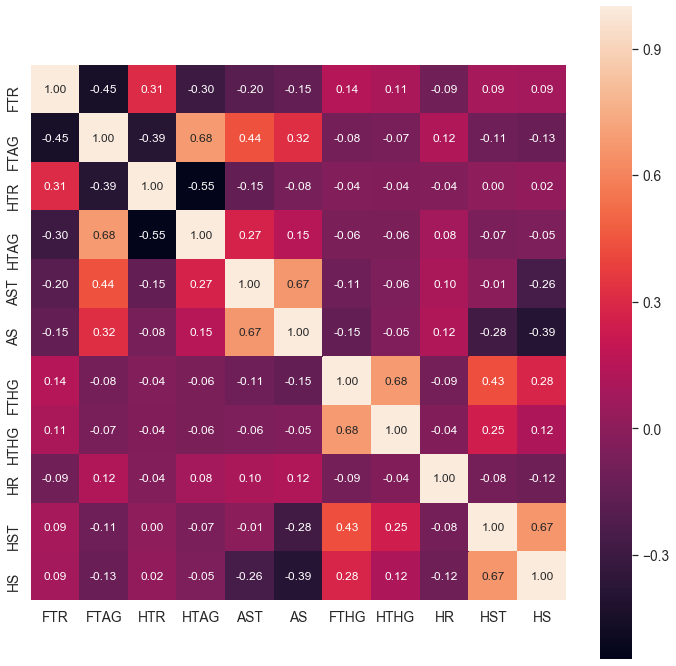

In [79]:
# plot the top 10 features related to FTR
def plotGraph(X_all, Y_all):

    train_data=pd.concat([X_all,Y_all],axis=1)

    #FTR correlation matrix
    plt.figure(figsize=(12,12))
    k = 11 # number of variables for heatmap
    cols = abs(train_data.astype(float).corr()).nlargest(k, 'FTR')['FTR'].index
    cm = np.corrcoef(train_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

attributes = raw_training_data.drop(['Date','HomeTeam', 'AwayTeam', 'Referee','FTR'],1)
attributes['HTR'] = attributes['HTR'].map({'H':1,'A':0,'D':2})
label = raw_training_data['FTR']
label = label.map({'H':1,'A':0,'D':2})
plotGraph(attributes,label)

As shown in the graph, the top 10 features are HTR, FTHG, HTHG, HST, HS, HR, AS, AST, HTAG,FTAG (ordered from the greatest to least). 

It is notable that the goal scored at full time (FTXG) & goal scored at half time (HTXG) and the total number of shots on goal (XS) & that on target (XST) are the two pairs of data which is highly correlated (>0.65).

So within the top 10 we pick the following attributes to create features:
- FTHG, FTAG -> the cumulative full time goal difference by home team and away team
- HS, AS -> the average number of shots on goal in the past 3 matches by home team and away team
- HR, AR (as features directly)

Additionally, we derive features by using:
- Date -> the delta time from last match of home team and away team
- HomeTeam, AwayTeam -> the distance needed to travel for the away team (with the help of extra data source)
- FTR -> the performance of past 3 matches of the home team and away team


In [80]:
selectedAttributes = ["Date","HomeTeam", "AwayTeam","FTR","FTHG","FTAG","HS","AS","HR","AR"]
training_data = raw_training_data[selectedAttributes]
training_data

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HR,AR
0,2008-08-16,Arsenal,West Brom,H,1,0,24,5,0,0
1,2008-08-16,Bolton,Stoke,H,3,1,14,8,0,0
2,2008-08-16,Everton,Blackburn,A,2,3,10,15,0,0
3,2008-08-16,Hull,Fulham,H,2,1,11,12,0,0
4,2008-08-16,Middlesbrough,Tottenham,H,2,1,14,8,0,0
...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,Liverpool,Wolves,H,2,0,13,7,0,0
4176,2019-05-12,Man United,Cardiff,A,0,2,26,13,0,0
4177,2019-05-12,Southampton,Huddersfield,D,1,1,10,10,0,0
4178,2019-05-12,Tottenham,Everton,D,2,2,11,17,0,0


### 3.2 Feature Construction

##### 3.2.1 Cumulative full time goal difference by home team and away team

As we have found that the number of matches per season is always the same, we can simply use i % 380 == 0 to check if it is a new season and to initialize the goal difference. 

In [81]:
# calculate the cumulative goal difference (before the current match) scored by home team and away team  
def getCumulativeGoalsDiff(data):
    teams = {}
    HCGD = [] 
    ACGD = []   

    # for each match
    for i in range(len(data)):
        
        if (i % 380 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']

        try:
            cgd_h = teams[data.iloc[i].HomeTeam].pop()
            cgd_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            cgd_h = 0
            cgd_a = 0

        HCGD.append(cgd_h)
        ACGD.append(cgd_a)
        cgd_h = cgd_h + FTHG - FTAG
        teams[data.iloc[i].HomeTeam].append(cgd_h)
        cgd_a = cgd_a + FTAG - FTHG
        teams[data.iloc[i].AwayTeam].append(cgd_a)

    data.loc[:,'HCGD'] = pd.Series(HCGD)
    data.loc[:,'ACGD'] = pd.Series(ACGD)

    return data

##### 3.2.2 Average number of shots on goal in the past 3 matches by home team and away team

In [82]:
# calculate the average number of shots on goal in the past 3 matches by home team and away team  
def getAverageShotsOnGoalInPast3Matches(data):
    teams = {}
    HAHS = [] 
    AAHS = []   

    # for each match
    for i in range(len(data)):
        
        if (i % 380 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = deque([None, None, None]) #[3rd, 2nd, latest data]

        try:
            ahs_h = np.mean(teams[data.iloc[i].HomeTeam])
            ahs_a = np.mean(teams[data.iloc[i].AwayTeam])
        except:
            ahs_h = None
            ahs_a = None

        HAHS.append(ahs_h)
        AAHS.append(ahs_a)

        teams[data.iloc[i].HomeTeam].popleft()
        teams[data.iloc[i].HomeTeam].append(data.iloc[i].HS)

        teams[data.iloc[i].AwayTeam].popleft()
        teams[data.iloc[i].AwayTeam].append(data.iloc[i].AS)

    data.loc[:,'HAHS'] = pd.Series(HAHS)
    data.loc[:,'AAHS'] = pd.Series(AAHS)

    return data

##### 3.2.3 Delta time from last match for home team and away team  

In [83]:
# calculate the delta time from last match for home team and away team  [done]
def getDeltaTime(data):
    
    teams = {}

    HDT = []
    ADT = []

    for i in range(len(data)):
        if (i % 380 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []    # to store last match date

        currentDate = data.iloc[i].Date

        try:
            homeLastMatchDate = teams[data.iloc[i].HomeTeam].pop()
            awayLastMatchDate = teams[data.iloc[i].AwayTeam].pop()

            hdt = (currentDate - homeLastMatchDate).days
            adt = (currentDate - awayLastMatchDate).days
        except:
            homeLastMatchDate = currentDate
            awayLastMatchDate = currentDate

            hdt = None
            adt = None

        HDT.append(hdt)
        ADT.append(adt)

        teams[data.iloc[i].HomeTeam].append(currentDate)
        teams[data.iloc[i].AwayTeam].append(currentDate)

    data.loc[:,'HDT'] = HDT
    data.loc[:,'ADT'] = ADT

    return data

##### 3.2.4 Distance needed to travel for the away team

The *geometricData* is an extra data source providing the latitude and longitude of teams

In [84]:
# get the distance needed to travel for the away team 
def getDistance(data, geometricData):
  array = []
  for x in data.iterrows():
   
    home_lat = (geometricData.loc[geometricData['Team'] == x[1].HomeTeam]).Latitude
    home_long = (geometricData.loc[geometricData['Team'] == x[1].HomeTeam]).Longitude
    home_location = (np.float32(home_lat), np.float32(home_long))
    
    away_lat = (geometricData.loc[geometricData['Team'] == x[1].AwayTeam]).Latitude
   
    away_long = (geometricData.loc[geometricData['Team'] == x[1].AwayTeam]).Longitude
    away_location = (np.float32(away_lat), np.float32(away_long))
    array.append(np.float32(geodesic(home_location, away_location).km))
  
  
  DIS = pd.Series(array)
  data.loc[:,'DIS'] = DIS

  return data

##### 3.2.5 Performances of last 3 matches of home team and away team

In [85]:
def getPerformanceOfLast3Matches(data):
    HM1 = []    # result of the last match of home team
    AM1 = []    # result of the last match of away team

    HM2 = []    # result of the 2nd last match of home team
    AM2 = []

    HM3 = []    # result of the 3rd last match of home team
    AM3 = []

    teams = {}

    for i in range(len(data)):
        
        if (i % 380 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = deque([None, None, None])  #[3rd, 2nd, latest data]

        HM3.append(teams[data.iloc[i].HomeTeam].popleft())
        AM3.append(teams[data.iloc[i].AwayTeam].popleft())
        HM2.append(teams[data.iloc[i].HomeTeam][0])
        AM2.append(teams[data.iloc[i].AwayTeam][0])
        HM1.append(teams[data.iloc[i].HomeTeam][1])
        AM1.append(teams[data.iloc[i].AwayTeam][1])

        if data.iloc[i].FTR == 'H':
            # 主场 赢，则主场记为赢，客场记为输
            teams[data.iloc[i].HomeTeam].append('W')
            teams[data.iloc[i].AwayTeam].append('L')
        elif data.iloc[i].FTR == 'A':
            # 客场 赢，则主场记为输，客场记为赢
            teams[data.iloc[i].AwayTeam].append('W')
            teams[data.iloc[i].HomeTeam].append('L')
        else:
            # 平局
            teams[data.iloc[i].AwayTeam].append('D')
            teams[data.iloc[i].HomeTeam].append('D')

    data.loc[:,'HM1'] = HM1
    data.loc[:,'AM1'] = AM1
    data.loc[:,'HM2'] = HM2
    data.loc[:,'AM2'] = AM2
    data.loc[:,'HM3'] = HM3
    data.loc[:,'AM3'] = AM3

    return data

##### 3.2.6 Derive features and remove invalid data

In [86]:
getCumulativeGoalsDiff(training_data)   # FTHG, FTAG -> HCGD, ACGD
getAverageShotsOnGoalInPast3Matches(training_data)  # HS, AS -> HAHS, AAHS
getDeltaTime(training_data)     # Date -> HDT, ADT
getDistance(training_data,geometricData)    # HomeTeam, AwayTeam -> DIS
getPerformanceOfLast3Matches(training_data) # FTR -> HM1,AM1, HM2,AM2, HM3,AM3 [latest,2nd,3rd]

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HR,AR,...,AAHS,HDT,ADT,DIS,HM1,AM1,HM2,AM2,HM3,AM3
0,2008-08-16,Arsenal,West Brom,H,1,0,24,5,0,0,...,NaN,NaN,NaN,165.772156,None,None,None,None,None,None
1,2008-08-16,Bolton,Stoke,H,3,1,14,8,0,0,...,NaN,NaN,NaN,70.146103,None,None,None,None,None,None
2,2008-08-16,Everton,Blackburn,A,2,3,10,15,0,0,...,NaN,NaN,NaN,45.151447,None,None,None,None,None,None
3,2008-08-16,Hull,Fulham,H,2,1,11,12,0,0,...,NaN,NaN,NaN,252.920654,None,None,None,None,None,None
4,2008-08-16,Middlesbrough,Tottenham,H,2,1,14,8,0,0,...,NaN,NaN,NaN,339.932465,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,Liverpool,Wolves,H,2,0,13,7,0,0,...,13.666667,8.0,8.0,108.891106,W,W,W,W,W,W
4176,2019-05-12,Man United,Cardiff,A,0,2,26,13,0,0,...,12.666667,7.0,8.0,229.968140,D,L,D,L,L,L
4177,2019-05-12,Southampton,Huddersfield,D,1,1,10,10,0,0,...,8.333333,8.0,7.0,306.418793,L,D,D,L,D,L
4178,2019-05-12,Tottenham,Everton,D,2,2,11,17,0,0,...,19.000000,8.0,9.0,283.650818,L,W,L,D,W,W


In [87]:
training_data.isnull().sum()

Date          0
HomeTeam      0
AwayTeam      0
FTR           0
FTHG          0
FTAG          0
HS            0
AS            0
HR            0
AR            0
HCGD          0
ACGD          0
HAHS        335
AAHS        335
HDT         111
ADT         111
DIS           0
HM1         110
AM1         110
HM2         219
AM2         221
HM3         331
AM3         329
dtype: int64

Now a few rows contain NaN values due to the lack of data in the begining of each year, we need to remove them.

In [88]:
training_data = removeInvalidData(training_data)
training_data

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HR,AR,...,AAHS,HDT,ADT,DIS,HM1,AM1,HM2,AM2,HM3,AM3
29,2008-09-13,Blackburn,Arsenal,A,0,4,10,17,0,0,...,19.666667,14.0,14.0,290.604156,L,W,D,L,W,W
32,2008-09-13,Man City,Chelsea,A,1,3,13,18,0,1,...,12.333333,13.0,13.0,261.179108,W,D,W,W,L,W
33,2008-09-13,Newcastle,Hull,A,1,2,13,8,1,0,...,9.333333,14.0,14.0,159.281448,L,L,W,D,D,W
34,2008-09-13,Portsmouth,Middlesbrough,H,2,1,21,7,0,0,...,14.666667,14.0,14.0,420.982727,W,W,L,L,L,W
35,2008-09-13,West Brom,West Ham,H,3,2,13,21,0,0,...,9.666667,14.0,14.0,175.303436,D,W,L,L,L,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,Liverpool,Wolves,H,2,0,13,7,0,0,...,13.666667,8.0,8.0,108.891106,W,W,W,W,W,W
4176,2019-05-12,Man United,Cardiff,A,0,2,26,13,0,0,...,12.666667,7.0,8.0,229.968140,D,L,D,L,L,L
4177,2019-05-12,Southampton,Huddersfield,D,1,1,10,10,0,0,...,8.333333,8.0,7.0,306.418793,L,D,D,L,D,L
4178,2019-05-12,Tottenham,Everton,D,2,2,11,17,0,0,...,19.000000,8.0,9.0,283.650818,L,W,L,D,W,W


### 3.3 Second Data Exploration

##### 3.3.1 Drop intermediate data

In [103]:
dropedAttributes = selectedAttributes.copy()
dropedAttributes.remove("HR")
dropedAttributes.remove("AR")
data = training_data.drop(dropedAttributes,1)
data

,HR,AR,HCGD,ACGD,HAHS,AAHS,HDT,ADT,DIS,HM1,AM1,HM2,AM2,HM3,AM3
29,0,0,-2,3,13.000000,19.666667,14.0,14.0,290.604156,L,W,D,L,W,W
32,0,1,4,5,12.000000,12.333333,13.0,13.0,261.179108,W,D,W,W,L,W
33,1,0,-2,-4,8.333333,9.333333,14.0,14.0,159.281448,L,L,W,D,D,W
34,0,0,-2,1,10.333333,14.666667,14.0,14.0,420.982727,W,W,L,L,L,W
35,0,0,-2,1,10.333333,9.666667,14.0,14.0,175.303436,D,W,L,L,L,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,0,0,65,3,16.333333,13.666667,8.0,8.0,108.891106,W,W,W,W,W,W
4176,0,0,13,-37,14.000000,12.666667,7.0,8.0,229.968140,D,L,D,L,L,L
4177,0,0,-20,-54,13.666667,8.333333,8.0,7.0,306.418793,L,D,D,L,D,L
4178,0,0,28,8,18.000000,19.000000,8.0,9.0,283.650818,L,W,L,D,W,W


##### 3.3.2 Numerical data analysis

In [111]:
numList = ['HR', 'AR', 'HCGD', 'ACGD', 'HAHS', 'AAHS', 'HDT', 'ADT', 'DIS']

We first print out the statistics of each numerical feature:

In [129]:
for col in numList:
    l = data[col].tolist() 
    print("\n" +"="*40)
    print("{} [size: {}]".format(col,len(l)))
    print("-"*40)
    print("min: {:.4f} \nmax: {:.4f} \nmedian:{:.4f}".format(np.min(l),np.max(l),np.median(l)))
    print("mean: {:.4f} \nvariance: {:.4f} \nstandard deviation: {:.4f}".format(np.mean(l),np.var(l), np.std(l, ddof=1)))


HR [size: 3845]
----------------------------------------
min: 0.0000 
max: 2.0000 
median:0.0000
mean: 0.0583 
variance: 0.0585 
standard deviation: 0.2419

AR [size: 3845]
----------------------------------------
min: 0.0000 
max: 2.0000 
median:0.0000
mean: 0.0887 
variance: 0.0891 
standard deviation: 0.2986

HCGD [size: 3845]
----------------------------------------
min: -54.0000 
max: 76.0000 
median:-2.0000
mean: -0.1545 
variance: 268.4770 
standard deviation: 16.3874

ACGD [size: 3845]
----------------------------------------
min: -54.0000 
max: 78.0000 
median:-2.0000
mean: 0.2195 
variance: 266.7305 
standard deviation: 16.3340

HAHS [size: 3845]
----------------------------------------
min: 3.3333 
max: 27.0000 
median:12.0000
mean: 12.4158 
variance: 12.0246 
standard deviation: 3.4681

AAHS [size: 3845]
----------------------------------------
min: 3.6667 
max: 28.6667 
median:12.3333
mean: 12.8305 
variance: 12.3910 
standard deviation: 3.5205

HDT [size: 3845]
---------

### 3.4 Data Transformation

##### 3.4.1 Split data

In [106]:
# separate the training data into feature set and label
X_all = data.copy()
y_all = training_data['FTR']

# separate the columns by type of values: 
categList = ["HM1","AM1", "HM2","AM2", "HM3","AM3"]
feature1 = ["DIS"]      # apply z-score normalization
feature2 = ["HCGD","ACGD"]  # apply logistic nomalization
feature3 = ["HR","AR","HAHS","AAHS","HDT","ADT"]    # apply min-max normalization

##### 3.4.2 Rescaling

In [ ]:
# min-max normalization
def rescale(data, cols):
    for col in cols:
        max = data[col].max()
        min = data[col].min()
        data[col] = (data[col] - min) / (max - min)
    return data

# z-score normalization
def standardize(data,cols):
    for col in cols:
        data[col] = scale(data[col])
    return data

##### 3.4.3 Transform categorical features

# 4. Methodology Overview [*Yanke*]

# 5. Model Training & Validation [*Yanke*]

# 6. Result [*Yi*]

# 7. Final Predictions on Test Set [*Yusi*]